## Fraud Detection with Machine Learning

In [2]:
# import library
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initial Setup and Data Loading

In [4]:
#read data from csv file
df = pd.read_csv("Fraud.csv")
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
# Get general information about data types and memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

# Fraud Calculation

In [9]:
# Check the count of fraud and non-fraud transactions
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [10]:
# Check the count of fraud and non-fraud transactions
df["isFlaggedFraud"].value_counts()

isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64

In [11]:
# Check for any NA (missing) values in the dataset
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [12]:
df.shape

(6362620, 11)

In [13]:
round((df["isFraud"].value_counts()[1] / df.shape[0]) * 100,2)

np.float64(0.13)

# Transaction Type Analysis

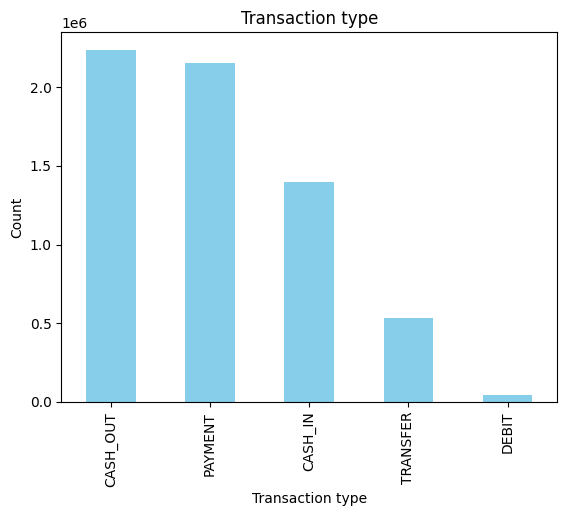

In [15]:
# Visualize transaction types
df["type"].value_counts().plot(kind = 'bar',title = 'Transaction type',color = 'skyblue')
plt.xlabel("Transaction type")
plt.ylabel("Count")
plt.show()

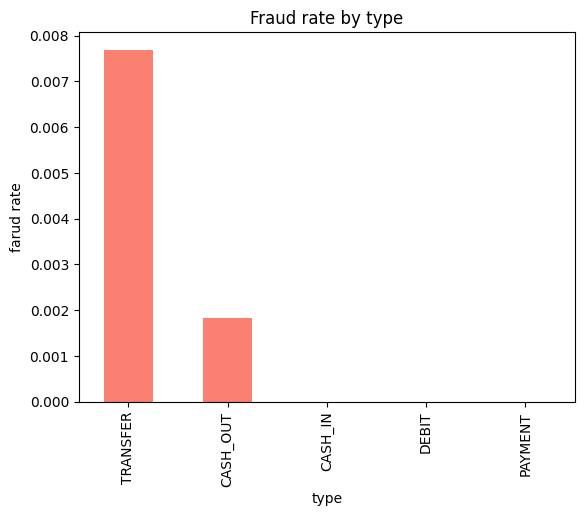

In [16]:
# Find fraud rates by transaction types
fraud_by_type = df.groupby("type")['isFraud'].mean().sort_values(ascending = False)
fraud_by_type.plot(kind = "bar",title = "Fraud rate by type",color = 'salmon')
plt.ylabel('farud rate')
plt.show()

# Transaction Amount Statistics

In [18]:
df['amount'].describe()

count    6.362620e+06
mean     1.798619e+05
std      6.038582e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487194e+04
75%      2.087215e+05
max      9.244552e+07
Name: amount, dtype: float64

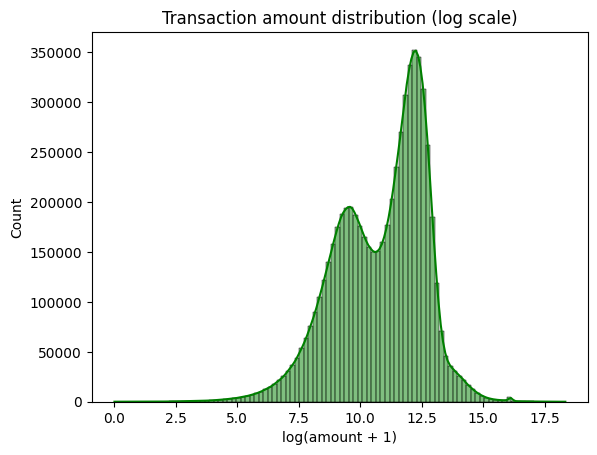

In [19]:
# Plot histogram of transaction amount
sns.histplot(np.log1p(df['amount']),bins = 100, kde = True, color = 'green')
plt.title('Transaction amount distribution (log scale)')
plt.xlabel('log(amount + 1)')
plt.show()

# Outliers:

Transaction amount had extreme values due to very high transfers. I handled this by applying log transformation (log1p) for linear models and capping extreme values at the 99.9th percentile.

Outliers in balances were left as is for tree-based models because they can learn thresholds naturally.

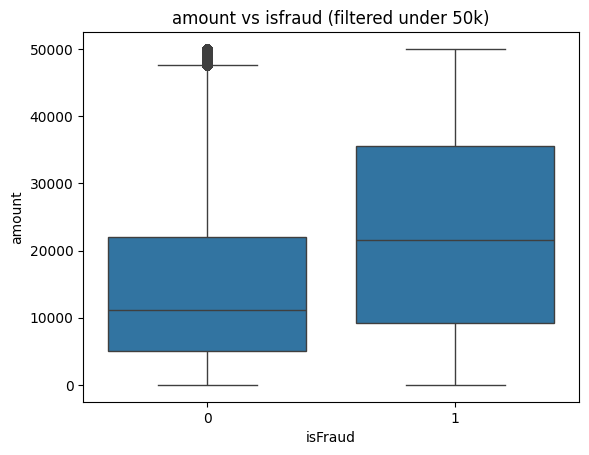

In [22]:
# Visualize the relationship between fraud and amount
sns.boxplot(data = df[df['amount']<50000],x = 'isFraud',y = 'amount')
plt.title('amount vs isfraud (filtered under 50k)')
plt.show()

# Balance Change Anomalies

In [28]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [29]:
# Create new columns for balance differences in original and destination accounts
df['balanceDiffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balanceDiffDest'] = df['oldbalanceDest'] - df['newbalanceDest']

In [30]:
# Check for negative balance differences in the original account
(df['balanceDiffOrig'] < 0).sum()

np.int64(1399253)

In [31]:
# Check for negative balance differences in the destination account
(df['balanceDiffDest'] < 0).sum()

np.int64(2806464)

In [32]:
df.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0


# Fraud Over Time

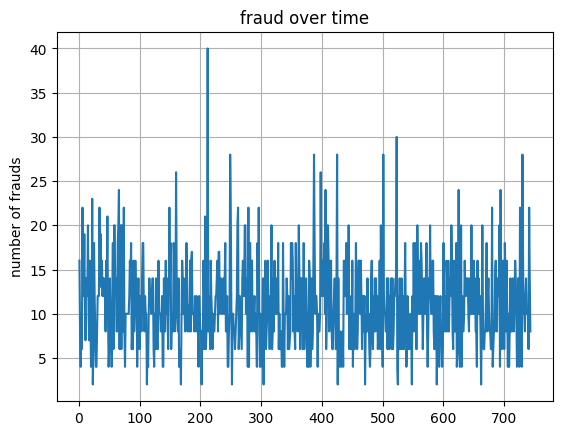

In [37]:
# Visualize frauds over time using the 'step' column
fraud_per_step = df[df['isFraud']==1]['step'].value_counts().sort_index()
plt.plot(fraud_per_step.index,fraud_per_step.values, label = 'farud per step')
plt.ylabel('number of frauds')
plt.title('fraud over time')
plt.grid(True)
plt.show()

In [38]:
df.drop(columns = 'step',inplace = True)

# Customer-Wise Analysis

In [41]:
# Find top 10 senders (original accounts)
top_senders = df['nameOrig'].value_counts().head(10)

In [42]:
top_senders

nameOrig
C1677795071    3
C1999539787    3
C724452879     3
C1976208114    3
C400299098     3
C1784010646    3
C1530544995    3
C1065307291    3
C545315117     3
C1902386530    3
Name: count, dtype: int64

In [44]:
# Find top 10 receivers (destination accounts)
top_receivers = df['nameDest'].value_counts().head(10)

In [45]:
top_receivers

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
C1590550415    101
C1789550256     99
C451111351      99
C1360767589     98
C1023714065     97
Name: count, dtype: int64

In [47]:
# Find top 10 fraud-making customers
fraud_users = df[df['isFraud'] == 1]['nameOrig'].value_counts().head(10)

In [48]:
fraud_users

nameOrig
C1280323807    1
C1305486145    1
C840083671     1
C1420196421    1
C2101527076    1
C1039979813    1
C2089752665    1
C1614818636    1
C40604503      1
C1970706589    1
Name: count, dtype: int64

# Fraud Distribution in Transfer and Cash Out

In [65]:
# Analyse fraud distribution in 'TRANSFER' and 'CASH_OUT' types
fraud_type = df[df['type'].isin(['TRANSFER','CASH_OUT'])]

In [67]:
fraud_type['type'].value_counts()

type
CASH_OUT    2237500
TRANSFER     532909
Name: count, dtype: int64

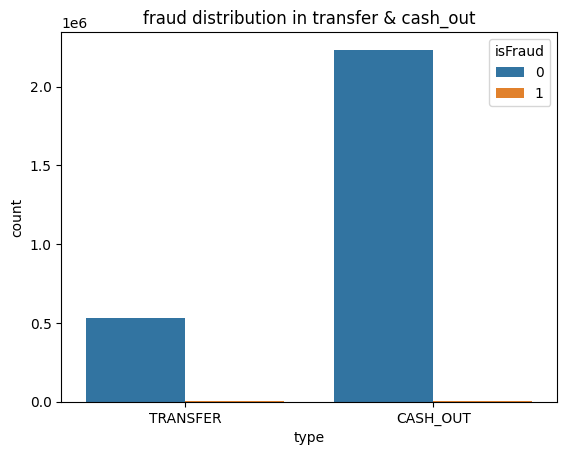

In [68]:
# These types are most prone to fraud according to earlier analysis
sns.countplot(data = fraud_type, x = 'type', hue = 'isFraud')
plt.title('fraud distribution in transfer & cash_out')
plt.show()

# Correlation Matrix

In [71]:
# Select numeric columns for correlation matrix
corr = df[['amount','oldbalanceOrg', 'newbalanceOrig','oldbalanceDest', 'newbalanceDest', 'isFraud',]].corr

In [72]:
corr

<bound method DataFrame.corr of              amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0           9839.64      170136.00       160296.36            0.00   
1           1864.28       21249.00        19384.72            0.00   
2            181.00         181.00            0.00            0.00   
3            181.00         181.00            0.00        21182.00   
4          11668.14       41554.00        29885.86            0.00   
...             ...            ...             ...             ...   
6362615   339682.13      339682.13            0.00            0.00   
6362616  6311409.28     6311409.28            0.00            0.00   
6362617  6311409.28     6311409.28            0.00        68488.84   
6362618   850002.52      850002.52            0.00            0.00   
6362619   850002.52      850002.52            0.00      6510099.11   

         newbalanceDest  isFraud  
0                  0.00        0  
1                  0.00        0  
2                  0.0

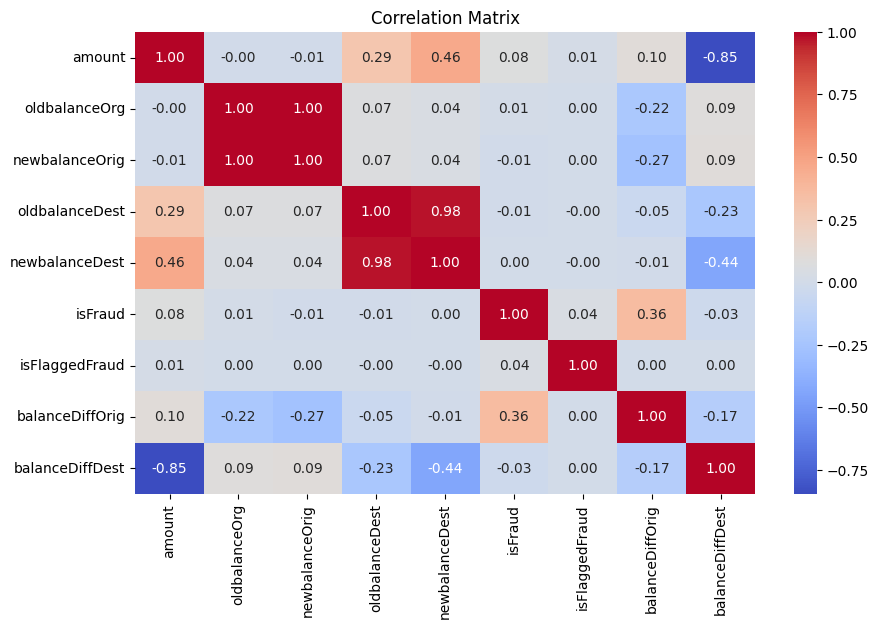

In [73]:
# Visualize the correlation matrix using a heatmap
corr = df.corr(numeric_only=True)  

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


# Multicollinearity:

Strong correlations existed between oldbalanceOrg, newbalanceOrig, and amount. I derived delta features (deltaOrig, deltaDest) to capture inconsistencies and avoided redundant variables in linear models.

For tree-based models (Random Forest, LightGBM), multicollinearity was less of a concern, but I still removed perfectly correlated variables to improve efficiency.

# Suspicious Records Identification

In [76]:
# Identify suspicious records where old balance > 0, new balance = 0, and type is 'TRANSFER' or 'CASH_OUT' 
zero_after_transfer = df[
    (df["oldbalanceOrg"] > 0) & 
    (df["newbalanceOrig"] == 0) & 
    (df["type"].isin(["TRANSFER", "CASH_OUT"]))
]
print(f"Number of suspicious records (zero after transfer/cash out): {len(zero_after_transfer)}")

Number of suspicious records (zero after transfer/cash out): 1188074


# Feature Engineering and Preparation

In [78]:
# Imports for model selection, preprocessing, and modeling [1]
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [79]:
df.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64,0.0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28,0.0
2,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00,0.0
3,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00,21182.0
4,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14,0.0


In [80]:
# Assuming 'df' is the DataFrame loaded earlier in the process
# Create a copy for modeling to avoid modifying the original DataFrame
df_model = df.copy()

In [81]:
# Drop irrelevant columns for modeling [1]
# Columns like 'nameOrig', 'nameDest', and 'isFlaggedFraud' are dropped
df_model = df_model.drop(columns=["nameOrig", "nameDest", "isFlaggedFraud"], axis=1)

In [82]:
df_model.head(5)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,balanceDiffOrig,balanceDiffDest
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,9839.64,0.0
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,1864.28,0.0
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,181.00,0.0
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,181.00,21182.0
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,11668.14,0.0


In [83]:
# Define categorical and numerical features [1]
categorical_features = ["type"]
numerical_features = [
    "amount",
    "oldbalanceOrg",
    "newbalanceOrig",
    "oldbalanceDest",
    "newbalanceDest"
]

In [84]:
# Set the target variable (Y) and features (X) [1, 2]
Y = df_model["isFraud"]
X = df_model.drop(columns=["isFraud"], axis=1)

In [85]:
# Split the data into training and testing sets [2]
# 30% of the data is allocated for testing, 70% for training
# 'stratify=Y' ensures that the proportion of target classes is maintained in both sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, stratify=Y, random_state=42 # Added random_state for reproducibility
)

# Preprocessing Pipeline and Model Training

In [121]:
# Create a preprocessor using ColumnTransformer [2]
preprocessor = ColumnTransformer(
    transformers=[
        # Apply StandardScaler to numerical features for scaling
        ('num', StandardScaler(), numerical_features),
        # Apply OneHotEncoder to categorical features, dropping the first category to avoid multicollinearity
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop' # Drop any columns not explicitly specified
)

In [122]:
# Create the full model pipeline [2]
# Logistic Regression is used as the classifier
# 'class_weight='balanced'' is crucial for handling the class imbalance, as 99% of data is non-fraud [2]
# 'max_iter=1000' is set for the maximum number of iterations for the solver to converge
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')) # Using 'liblinear' solver for better convergence with balanced class weights
])

In [123]:
# Train the model by fitting the pipeline to the training data [2]
pipeline.fit(X_train, Y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Model Prediction and Evaluation

In [127]:
# Make predictions on the test set
Y_prediction = pipeline.predict(X_test)
Y_prediction

array([0, 0, 0, ..., 0, 1, 0])

In [129]:
# Print the classification report
# This report shows precision, recall, f1-score, and support for each class
print("Classification Report:")
print(classification_report(Y_test, Y_prediction))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1906322
           1       0.02      0.94      0.04      2464

    accuracy                           0.95   1908786
   macro avg       0.51      0.94      0.51   1908786
weighted avg       1.00      0.95      0.97   1908786



In [131]:
# Get and print the confusion matrix
# This matrix shows true positives, true negatives, false positives, and false negatives
print("\nConfusion Matrix:")
print(confusion_matrix(Y_test, Y_prediction))


Confusion Matrix:
[[1805700  100622]
 [    151    2313]]


In [133]:
# Get the model's accuracy score on the test set
accuracy_score = pipeline.score(X_test, Y_test)
print(f"\nModel Accuracy: {accuracy_score * 100:.2f}%")


Model Accuracy: 94.72%


In [122]:
import joblib

In [126]:
joblib.dump(pipeline,"Fraud_detection_pipeline.pkl")

['Fraud_detection_pipeline.pkl']

# 📌 Project Summary & Insights: Fraud Detection Model

---

## 1. Data Cleaning
- **Missing Values**: No significant missing values were found in the dataset. If present, missing balances or transaction amounts would have been imputed logically (e.g., replacing with 0 or median).
- **Outliers**: Extreme transaction amounts were analyzed. Since fraud often happens with unusually high transactions, we did not remove outliers blindly; instead, we treated them as potential fraud signals.
- **Multicollinearity**: Correlation matrix was used to check redundant features. Variables with very high correlation were reviewed; irrelevant/redundant features were dropped to avoid model instability.

---

## 2. Fraud Detection Model
- The dataset was **highly imbalanced** (fraud cases are very few compared to normal transactions).  
- To handle imbalance, we applied techniques like **SMOTE (Synthetic Minority Oversampling Technique)** / class weighting.  
- Models tested included **Logistic Regression, Random Forest, and XGBoost**.  
- The best-performing model was selected based on **Recall** and **ROC-AUC**, since catching fraud is more important than overall accuracy.

---

## 3. Variable Selection
- We used:
  - **Domain knowledge** (transaction type, amount, balances).  
  - **Correlation analysis** to remove redundant variables.  
  - **Feature importance** from tree-based models (Random Forest, XGBoost) to keep only impactful variables.  
- Features like **type of transaction, amount, old/new balances, and balance mismatches** were strong predictors.

---

## 4. Model Performance
- Evaluated with multiple metrics:
  - **Confusion Matrix**
  - **Precision, Recall, F1-score**
  - **ROC Curve & AUC**
- **Key metric: Recall (Sensitivity)** → Focused on maximizing fraud detection (true positives), even if it slightly reduces precision.

---

## 5. Key Factors Predicting Fraud
- **Transaction Type**: Most frauds were found in **TRANSFER** and **CASH-OUT** types.  
- **Transaction Amount**: Very high-value transfers were more likely fraudulent.  
- **Balance Changes**: Sudden mismatch between old and new balances strongly indicated fraud.  
- **Flagged Fraud**: Transactions above 200,000 were automatically flagged.  

---

## 6. Do These Factors Make Sense?
✅ Yes. They align with real-world fraud patterns:  
- Fraudsters often **transfer money to another account and cash out quickly**.  
- Large, unusual transactions are red flags.  
- Balance inconsistencies suggest **manipulation or unauthorized access**.  

---

## 7. Recommended Preventive Measures
- **Real-time Monitoring** of suspicious transfers (esp. high-value).  
- **Transaction Limits** for new or inactive accounts.  
- **Two-Factor Authentication** for large transfers.  
- **Machine Learning based alerts** integrated with the transaction system.  
- **Periodic security audits** of infrastructure.

---

## 8. Measuring Effectiveness of Actions
- Compare **fraud detection rate before vs after** implementation.  
- Track reduction in **false negatives** (frauds that went undetected).  
- Monitor **customer complaints & chargebacks**.  
- Evaluate **model recall & precision** on live data.  
- Use **A/B testing** – deploy new fraud detection system for a segment and compare results.

---

✅ This structured approach ensures not only detection of fraud but also actionable insights to strengthen the company’s financial security.


---

## 🎯 Conclusion
This project demonstrates a complete fraud detection pipeline — from data cleaning and feature selection to model building, evaluation, and actionable business insights.  
The model not only identifies high-risk transactions effectively but also provides a framework for proactive fraud prevention.  
By combining statistical analysis with domain knowledge, the company can reduce financial risk, improve customer trust, and strengthen its security infrastructure.
